In [1]:
import numpy as np
import math
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy.optimize as opt
import os
import sys

fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
# spans two rows:
ax3 = fig.add_subplot(gs[:, 1])

*April 2021*
Representation and Interaction

## Multiagent search of lost targets 2D in a static world using range sensors (II)

**Author**: Pablo Lanillos Donders Institute


### Description of the problem

<br/>
<img src="img/problem-definition.png" width="150" style="float: left;" />
This document describes the assignment. The goal of this assignment is to program an algorithm that let multiple searching agents to find the survivors as soon as possible. In other words, the algorithm should compute the optimal actions for the UAVs. In practice it extends previus notebook algorithm to $M$ agents with shared communication and continuous actions.

The document is composed of the following sections:

1. Multiagent search greedy 1 step discrete no communication
2. Multiagent search greedy 1 step discrete common belief
3. Multiagent search n-step continuous optimization (centralized)
4. Heterogenous sensors (only in the report)

**Important note:**
We will code the solution, instead of using the jupyter notebook, with a normal python script (i.e., Name_Surname_multiagent_RI_2021.py) using your favorite IDE (e.g., PyCharm Community, https://www.jetbrains.com/pycharm/download/). This document is a helper to develop your own code. Please, follow the instructions provided for naming the code. The submission (as explained in the readme) is a python file that is able to run the 3 modes of the algorithm.

A variable *exercise* in the beginning of the code will define one of the following behaviours:
   - exercise = 1 - Multiagent search greedy 1 step discrete no communication.
   - exercise = 2 - Multiagent search greedy 1 step discrete common belief.
   - exercise = 3 - Multiagent search n-step continuous centralized optimization.

*It is extremly important that you code is clean for proper evaluation*

**References**: 
- Lanillos, P. (2013): Minimum time search of moving targets in uncertain environments. Ph.D. Dissertation. url: 
http://www.therobotdecision.com/papers/PhD_MinimumTimeSearch_2013_FinalElectronic_English_PabloLanillos.pdf

*Continuous*
- Lanillos, P., Gan, S. K., Besada-Portas, E., Pajares, G., & Sukkarieh, S. (2014). Multi-UAV target search using decentralized gradient-based negotiation with expected observation. Information Sciences, 282, 92-110.

*Discrete*
- Lanillos, P., Besada-Portas, E., Pajares, G., & Ruz, J. J. (2012, October). Minimum time search for lost targets using cross entropy optimization. In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems (pp. 602-609). IEEE.


### Import needed libraries

In [7]:
# Numpy numerical library -> import [library] as name
import numpy as np

# Plotting libraries -> matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # 3D plots
from matplotlib import cm # Color maps
import math

# Matrix auxiliary functions
import numpy.matlib

# System libraries
import os
import sys

### 1. Multiagent search greedy 1 step discrete no communication

#### Observation model reminder
Remember to use for all exercises the same values for the sensor

In [8]:
Pdmax = 0.8 # Max range sensor
dmax = 4 # Max distance
sigma = 0.7 # Sensor spread (standard deviation)
delta = 0.5 # Constant displacement
mat = [[0, 0], [-delta, 0], [-delta, delta], [0, delta], [delta, delta], [delta, 0], [delta, -delta], [0, -delta], [-delta, -delta]]

In [9]:
width = height = 40
# x, y = np.arange(width), np.arange(height)
map_size = np.array([width, height])
X, Y = np.meshgrid(np.arange(map_size[0]), np.arange(map_size[1])) 

map_x = X.flatten() # Convert matrix into a single vector useful for operating 
map_y = Y.flatten() # Convert matrix into a single vector useful for operating 

## Write your code here
# Compute the sensor P(\overline{D}) with a function with name 
# def sensor_pnd( ... ):
def sensor_pnd(d, dmax, Pdmax, sigma):
    return 1 - Pdmax*math.exp(-sigma*(d/dmax)**2)

def distance(xi, xj, i, j):
    return math.sqrt((i - xi)**2 + (j - xj)**2)

# Plot the sensor
# width = height = 40 # Size of the environment
# map = np.zeros((width, height))
# for i in map_x:
#     for j in map_y:
#         d = distance(x[0], x[1], i, j)
#         map[i, j] = sensor_pnd(d, dmax, Pdmax, sigma)
print(Y)

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [37 37 37 ... 37 37 37]
 [38 38 38 ... 38 38 38]
 [39 39 39 ... 39 39 39]]


#### Agent class
We first code the agent as a python class to do a modular programming approach that will aid in the design of the final algorithm


In [25]:
class Agent:

    # Constructor
    def __init__(self, i, bk, env, state=np.array([0.,0.])):
        
        self.id = i  # Create an instance variable
        
        ## Environment. Tip it would be efficient to compute the grid into one vector as we did in the previous notebook        
#         X, Y = np.meshgrid(map_size[0], map_size[1])
#         self.map_x = X.flatten()
#         self.map_y = Y.flatten()
        
        self.bk = bk
        self.env = env

        ## Agent params
        self.x = state
        self.track = self.x.T # Stores all positions. Aux variable for visualization of the agent path
        self.height_plot = 0.1
        
        # add extra agents params
        
        ## Sensor params
        

    # get id
    def get_id(self):
        return self.id

    # compute discrete forward states 1 step ahead
    def forward(self):
        return np.random.permutation(
            [[a+self.x[0], b+self.x[1]] for [a, b] in self.env.mat if a+self.x[0] >= 0 
             and a+self.x[0] < 40 and b+self.x[1] >= 0 and b+self.x[1] < 40])
        
    # computes utility of forward state
#     def nodetect_observation(self, x):
#         pnd = []
#         return pnd
    
    # computes utility of states
    def utility(self, fs):
        # compute cost funtion J of all potential forward states (brute force method)
        J = []
        for state in fs:
            utility = 0
            for x in range(self.env.width):
                for y in range(self.env.height):
                    d = distance(state[0], state[1], x, y)
                    utility += sensor_pnd(d, dmax, Pdmax, sigma)*self.bk[x, y]
            J.append(utility)
        return J
    
    def next_best_state(self):
        fs = self.forward()
        J = self.utility(fs)
#         print(fs)
#         print(J)
#         print(fs[J.index(min(J))])
        return fs[J.index(min(J))]
      
    # simulate agent next state
    def next(self, state):
        self.x = state
        self.track = np.vstack((self.track, self.x))

    # update belief with observation at state self.x
    def update_belief(self):
        for x in range(self.env.width):
            for y in range(self.env.height):
                d = distance(self.x[0], self.x[1], x, y)
                self.bk[x, y] = sensor_pnd(d, dmax, Pdmax, sigma)*self.bk[x, y]
        self.bk = self.bk/np.sum(self.bk)
      
    def plot(self, ax):
        # Reshape belief for plotting
        bkx = self.bk.reshape((self.env.width, self.env.height))
        ax.cla() # clear axis plot
        
        # plot contour of the P(\tau) -> self.bk
#         cset = ax.contourf(X, Y, bkx, zdir='z', offset=-0.005, cmap=cm.viridis)

        # plot agent trajectory, self.track
        ax.plot(self.track[:, 0], self.track[:, 1], np.ones(self.track.shape[0]) * self.height_plot, 'r-', linewidth=2);
        ax.plot([self.track[-1, 0], self.track[-1, 0]], [self.track[-1, 1], self.track[-1, 1]], [self.height_plot, 0], 'ko-', linewidth=2);

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('P')

        # Adjust the limits, ticks and view angle
        ax.set_zlim(0, 0.12)
        ax.view_init(27, -21)
    

In [11]:
# Create agent 0, move it to position (0,0) and plot it
a = Agent(0)
a.next(np.array([0,0]))
fig = plt.figure()
ax = fig.gca(projection='3d')
a.plot(ax)

TypeError: __init__() missing 2 required positional arguments: 'bk' and 'env'

In [12]:
# Create agent 1 in position(5,5) and agent 2 in position (30,30)
# with initial belief the Gaussian distribution 
# with mean in the middle of an environment of 40x40 and covariance [[40,0], [0,60]]
# Remember to normalize the belief
a1 = Agent(1, np.array([5,5]))
a1.next(np.array([5,5]))
a2 = Agent(2, np.array([30,30]))
a2.next(np.array([30,30]))

# Plot the agents        
fig1 = plt.figure("agent 1")
ax1 = fig1.gca(projection='3d')
a1.plot(ax1)
fig2 = plt.figure("agent 2")
ax2 = fig2.gca(projection='3d')
a2.plot(ax2)



TypeError: __init__() missing 1 required positional argument: 'env'

#### Handling multiple agents
We create a list of agents $l = [a_1,a_2,\ldots,a_M]$ and we iterate over it in a python way: 

In [13]:
agents = []
agents.append(Agent(0)) # add agent
agents.append(Agent(1))
agents.append(Agent(2))

for a in agents:
    #compute
    pass
    

TypeError: __init__() missing 2 required positional arguments: 'bk' and 'env'

#### Code your code in a python script

Now that you know how to program the agent class we will create a python script using your preferred IDE (Name_Surname_multiagent_RI_2021.py). You will program there the algorithm as follows:

-------------------------------------------------

> M-Agents search 2D (1 n-step ahead no comm)



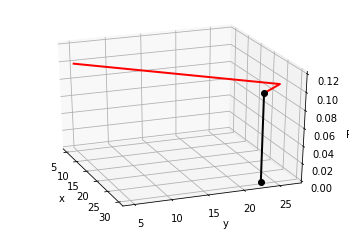

In [27]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors

import scipy.optimize as opt

import os
import sys

def bivariate_gaussian(w, h, mu, Sigma, X, Y):
    COV_1 = np.linalg.inv(Sigma) # Compute the inverse Sigma^-1
    p = np.zeros(w*h) # probability map
    d = np.array([X.ravel()-mu[0],Y.ravel()-mu[1]]) # distances (x- \mu)
    # Compute probability of each point
    for i in range(0,w*h):
        p[i] = np.exp(- 0.5 * d[:,i].dot(COV_1).dot(d[:,i].transpose()))
    p = p/np.sum(p) # normalize to sum to 1
    P = p.reshape((w, h)) # rank 2 square matrix 
    return P

# class Agent:
    # Complete the agent class
#     pass
    
class Environment:
    # Use it to store parameters and for ploting functions
    def __init__(self, map_size = np.array([40, 40]), sigma = np.array([[40,0],[0,60]])):
        self.width = map_size[0]
        self.height = map_size[1]
        self.X, self.Y = np.meshgrid(np.arange(self.width), np.arange(self.height))
        self.mu = np.array([self.width/2., self.height/2.]) # center point
        self.sigma = sigma # Bimodal covariance with no dependence.
        self.mat = [[0, 0], [-delta, 0], [-delta, delta], [0, delta], [delta, delta], [delta, 0], [delta, -delta], [0, -delta], [-delta, -delta]]
        

print('-------------------------------------------------\n');
print('> M-Agents search 2D (1 n-step ahead no comm)\n')

nagents = 2
# Create environment
env = Environment()

# Create bivariate gaussian distribution
belief = bivariate_gaussian(env.width, env.height, env.mu, env.sigma, env.X, env.Y)

# Create agents
agents = []
a0 = Agent(0, belief, env, np.array([5,5]))
# a0.next(np.array([5,5]))
agents.append(a0)
a1 = Agent(1, belief, env, np.array([30,30]))
# a1.next(np.array([30,30]))
# agents.append(a1)

# Global plot for animations
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.ion()

# Start algorithm
ite = 0  # iteration count
nite = 50  # number of iterations
found = 0  # target found

## start search
while not found and ite < nite:

    for a in agents:
        a.next(a.next_best_state())
        a.update_belief()
        ax.set_zlim(-0.005,0.004)
        ax.view_init(27, -21)
        a.plot(ax)
    
#     cset = ax.contourf(X, Y, belief, zdir='z', offset=-0.005, cmap=cm.viridis)
#     ax.set_zlim(-0.005,0.004)
#     ax.view_init(27, -21)
    
    # plot
    plt.draw()
#     plt.pause(0.1)  # animation

    # iteration count
    ite += 1
    
# for a in agents:
#     ax.set_zlim(-0.005,0.004)
#     ax.view_init(27, -21)
#     a.plot(ax)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, agents[0].bk, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
# cset = ax.contourf(X, Y, agents[0].bk, zdir='z', offset=-0.002, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
# ax.set_zlim(-0.002,0.001)
# ax.view_init(27, -21)
# plt.show()

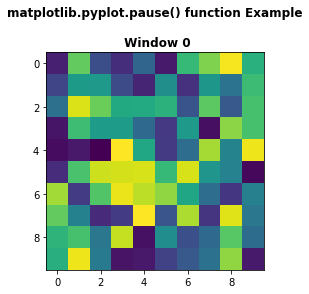

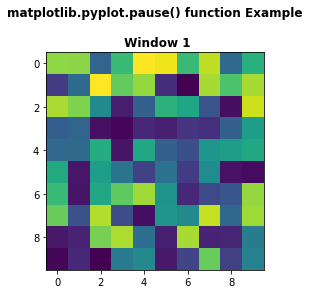

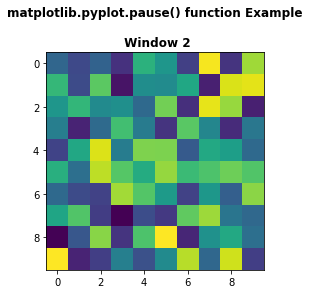

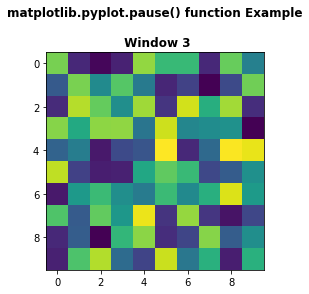

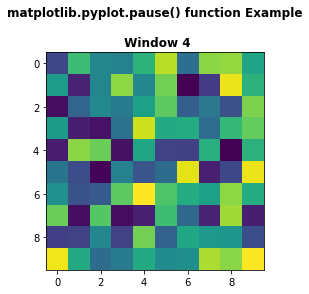

In [28]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt
   
np.random.seed(19)
data = np.random.random((5, 10, 10))
  
   
for i in range(len(data)):
    plt.cla()
    plt.title('matplotlib.pyplot.pause() function Example\n\n Window {}'.format(i), fontweight ="bold")
    plt.imshow(data[i])
    plt.pause(0.1)

### 2. Multiagent search greedy 1 step discrete common belief

Extend your previous code to enable the agents share a global shared belief representation


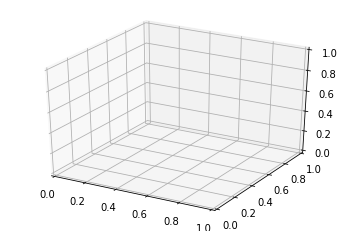

<Figure size 432x288 with 0 Axes>

In [15]:
nagents = 2
# Create environment

# Create agents

# Global plot for animations
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.ion()

# Start algorithm
ite = 0  # iteration count
nite = 2  # number of iterations
found = 0  # target found

# Initialize common belief  bk = prior probability map p(\tau)

## start search
while not found and ite < nite:

    # Compute next best state for each agent given the common belief
    
    # Update common belief
        
    # plot
    plt.draw()
    plt.pause(0.1)  # animation

    # iteration count
    ite += 1

### 3. Multiagent search n-step continuous optimization (centralized)

This section is the most advanced one. Agents will select the n-actions ahead collaborativelly that maximize the probability of finding the survivors. In this case the agents instead of discrete actions will perform continuous pice-wise actions:

<img src="img/actions-continuous.png" width="400" />

From state $s^k$ at time step $k$ to time step $k+1$ the agent perform the turn action $u^k$ (constant) that makes the UAV to change its heading. Then, when arriving at state $s^{k+1}$ the agent makes an observation $z^k$.


#### Agent dynamics
We define the agent state the $s = \{x,y,\phi\}$, where $\phi$ is the turning angle. The state dynamics $\dot{s}$ are defined by its differential equations. Below I provide the function to compute the next state given the action (turn rate).

In [2]:
class AgentContinuos():

    # Constructor
    def __init__(self):
        self.V = 2  # Velocity of the agent
        self.dt = 1  # Interval for euler integration (continuous case)
        self.max_turn_change = 0.2  # Max angle turn (action bounds)
        
        self.x = np.array([5,5,0.2])
        self.track = self.x.T # Stores all positions
        
    # set next state
    def next(self, vk):
        # singular case u = 0 -> the integral changes
        if vk == 0:
            self.x[0] = self.x[0] + self.dt * self.V * np.cos(self.x[2])
            self.x[1] = self.x[1] + self.dt * self.V * np.sin(self.x[2])
            self.x[2]= self.x[2]
        else:
            desp = self.V / vk
            if np.isinf(desp) or np.isnan(desp):
                print('forwardstates:V/u -> error');
            self.x[0] = self.x[0] + desp * (np.sin(self.x[2] + vk * self.dt) - np.sin(self.x[2]))
            self.x[1] = self.x[1] + desp * (-np.cos(self.x[2] + vk * self.dt) + np.cos(self.x[2]))
            self.x[2] = self.x[2] + vk * self.dt

        self.track = np.vstack((self.track, self.x))


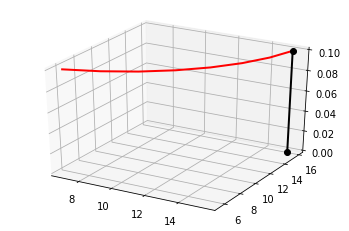

In [3]:
a = AgentContinuos()

# an example of ploting 8 steps of the agent trajectory
for i in range(8):
    a.next(0.15)

# plot agent trajectory, self.track   
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(a.track[:, 0], a.track[:, 1], np.ones(a.track.shape[0]) * 0.1, 'r-', linewidth=2);
ax.plot([a.track[-1, 0], a.track[-1, 0]], [a.track[-1, 1], a.track[-1, 1]], [0.1, 0], 'ko-', linewidth=2);
plt.show()

    

#### Multiagent utility function
We need a function that evaluates how good are the actions of the team. We have $M$ agents and we want to compute the $N$ step ahead actions that optimize the following function:

$$ U(x) = \int_{\tau^k} \left[\prod_{j=0}^N \prod_{i=0}^M p(\overline{D}| x_{i}^{k+j},\tau)\right] b_\tau^{k-1} d\tau$$

Remember that the state $x^{k+1}$ is directily obtained by a function of the previous state $x^{k}$ and the action $u^k$

*What changes in this utility function if we only have one agent?*

In [101]:
def multi_utility(uk, agents, N, bk):
    value = 1
    for j in range(N):
        for a in agents:
            a.next(uk)
            for x in range(env.width):
                for y in range(env.height):
                    d = distance(a.x[0], a.x[1], x, y)
                    value *= sensor_pnd(d, dmax, Pdmax, sigma)
    np.dot(bk, value)
    return value

#### Optimizer
In order to compute the best actions we will use a general optimizer from scipy python library. The optimizer returns the best actions found.

In [1]:
import scipy.optimize as opt

class Optimizer:

    def __init__(self):
        self.method = 'trust-constr' # Optimization method
        self.jac = "2-point" # Automatic Jacobian finite differenciation
        self.hess =  opt.SR1() # opt.BFGS() method for the hessian computation
        self.ul = np.pi / 4  # Max turn constraint for our problem (action limits). How much the vehicle can turn

    # fun - function to optimize, 
    # x0 - variables initialization (velocities at each instant), 
    # agents - structure with the information of each agent
    # N - steps ahead
    # bk - current belief of the environment. Probability of finding the target.
    def optimize(self, fun, x0, agents, N, bk):
        # write your optimization call using scipy.optimize.minimize
        n = x0.shape[0]
        # Define the bounds of the variables in our case the limits of the actions variables, here the velocties
        bounds = opt.Bounds(np.ones(n) * (-self.ul), np.ones(n) * self.ul) 
        # minimize the cost function. Note that I added the as arguments the extra variables needed for the function.
        res = opt.minimize(fun, x0, args=(agents, N, bk), method=self.method, jac=self.jac, hess=self.hess, bounds=bounds)
        #  options={'verbose': 1})
        return res

Note that the function (*fun*) optimized is the multiagent utility function. Furthermore, *x0* is the initial state of the variables to be optimized. Here, we are optimizing the turnrate of each agent at each time step. A wise initialization is to set all turnrates to some number close to 0, like 0.001. Initializing with zeroes it is also possible but could give converngence problems. 

#### Final code
Extend to your python code with the centralized optimization using 3 agents with continuous actions and that select the best actions using the optimizer. A plot of the agents working:

<img src="img/solution-continuous.png" width="400" />


### 4. Heterogeneous sensors

Describe in the report how you can model agents with different sensors and how the utility function will change and the rest of the algorithm.

## Summary and submission
Submit the report and the python code **Name_Surname_multiagent_RI_2021.py**. A variable in the beginning of the code defines one of the following behaviours:
   - exercise = 1 - Multiagent search greedy 1 step discrete no communication.
   - exercise = 2 - Multiagent search greedy 1 step discrete common belief.
   - exercise = 3 - Multiagent search n-step continuous centralized optimization.



#### Remark: You have learned to code a state-of-the-art algorithm for multiagents systems in the presence of uncertainty. Several applications can be faced: Search and Rescue, Monitoring, Service robotics, etc. 
> Hope you enjoyed the assignment. Pablo Lanillos. *Representation & Interaction 2021*